In [1]:
import numpy as np
import pandas as pd
import mpu

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

* Trips with 0 passenger count should be replaced with mode value which is 1
* Outliers in the passenger count should be handled using IQR replace (Make sure it is an interger)
* remove those trips which covered 0 km distance but clocked more than 1 minute to make our data more consistent for predictive model
* Remove trips which covered a distance of <=1km but duration is more than or equal to 1 hr
* data = data[data.pickup_longitude != data.pickup_longitude.min()]
* Don't remove longitude and latitude information from the data frame

In [2]:
nyc_trip_duration = pd.read_csv('nyc_taxi_trip_duration.csv')
nyc_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848
...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447


### Feature generation:

In [3]:
# Date columns: 
dates_list = ['pickup_datetime','dropoff_datetime']

# Converting date time information to the date time data type:
for date_col in dates_list:
    nyc_trip_duration[date_col] = pd.to_datetime(nyc_trip_duration[date_col])

# Extracting Year, Month, Day name, hour of the day converted to categories (Morning, Noon, etc.):
nyc_trip_duration['pickup_month'] = nyc_trip_duration['pickup_datetime'].dt.month
nyc_trip_duration['pickup_week_num'] = nyc_trip_duration['pickup_datetime'].dt.week
nyc_trip_duration['pickup_day_name'] = nyc_trip_duration['pickup_datetime'].dt.day_name()
nyc_trip_duration['pickup_hour'] = nyc_trip_duration['pickup_datetime'].dt.hour


In [4]:
# Calculating trip distance using latitude and longitude information:
nyc_trip_duration['trip_distance'] = list(map(mpu.haversine_distance, zip(nyc_trip_duration['pickup_latitude'], nyc_trip_duration['pickup_longitude']), zip(nyc_trip_duration['dropoff_latitude'], nyc_trip_duration['dropoff_longitude'])))

#Calculate Speed in km/h for further insights
nyc_trip_duration['trip_speed'] = (nyc_trip_duration.trip_distance/(nyc_trip_duration.trip_duration/3600))

In [5]:
nyc_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_week_num,pickup_day_name,pickup_hour,trip_distance,trip_speed
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,2,9,Monday,16,1.199073,10.791654
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,3,10,Friday,23,4.129111,13.513454
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,2,7,Sunday,17,7.250753,15.964960
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,1,1,Tuesday,9,2.361097,7.449562
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,2,7,Wednesday,6,4.328534,18.375851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296,5,20,Saturday,13,1.120223,13.624333
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315,2,8,Monday,0,0.728705,8.328053
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673,4,15,Friday,18,2.298776,12.296570
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447,6,24,Sunday,9,0.846316,6.815966


### Data Pre-processing:

In [6]:
# Replacing passenger count 0 with 1 as 1 is the mode of the passenger count based on EDA:
nyc_trip_duration['passenger_count'] = nyc_trip_duration['passenger_count'].apply(lambda x: 1 if x==0 else x)

# Replacing outliers 7 and 9 passenger count with 6:
nyc_trip_duration['passenger_count'] = nyc_trip_duration['passenger_count'].apply(lambda x: 6 if x > 6 else x)

In [7]:
# Dropping rows whose trip distance = 0 and trip duration >= 1 min (data inconsistencies as per EDA):
nyc_trip_duration = nyc_trip_duration.loc[~((nyc_trip_duration.trip_distance == 0) & (nyc_trip_duration.trip_duration>=60))]

In [8]:
# Dropping of unnecessary columns:
nyc_trip_duration = nyc_trip_duration.drop(['id','pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)

#### Handling outliers:

In [9]:
# Function to handle outliers:
def outlier_handling(df_original, col_name, method = 'IQR', replace = True):
    
    df = df_original.copy()
    
    # Handling outliers using IQR method:
    if method == 'IQR':        
        # 1st Quartile and 3rd Quartile: 
        Q1 = df[col_name].quantile(0.25)
        Q3 = df[col_name].quantile(0.75)
        # Interquartile range and whisker width:
        IQR = Q3-Q1
        whisker_width = 1.5
        # Lower and Upper whiskers:
        lower_whisker = Q1 - (whisker_width * IQR)
        upper_whisker = Q3 + (whisker_width * IQR)
        
        if replace == True:
            # Replacing outliers with respective whiskers:
            print('Replacing outliers using IQR')
            df.loc[df[col_name] > upper_whisker, col_name] = upper_whisker
            df.loc[df[col_name] < lower_whisker, col_name] = lower_whisker
        else:
            # Dropping outliers: (Not recommended as the entire row values of all columns are dropped along with the outliers leading to data loss)
            print('Dropping outliers using IQR')
            df = df.loc[df[col_name] <= upper_whisker]
            df = df.loc[df[col_name] >= lower_whisker]
    
    ## Handling outliers using Standard deviation method:
    elif method == 'STD':
        # Higher end standard deviation value (Mean + 3 * standard deviation):
        high_std_val = df[col_name].mean() + 3 * df[col_name].std()
        # Lower end standard deviation value (Mean - 3 * standard deviation):
        low_std_val = df[col_name].mean() - 3 * df[col_name].std()
        
        if replace == True:
            # Replacing outliers with higher and lower end standard deviation values of the column:
            print('Replacing outliers using Standard deviation')
            df.loc[df[col_name] > high_std_val, col_name] = high_std_val
            df.loc[df[col_name] > low_std_val, col_name] = low_std_val
        else:
            # Dropping outliers: (Not recommended as the entire row values of all columns are dropped along with the outliers leading to data loss)
            print('Dropping outliers using Standard deviation')
            df = df.loc[df[col_name] <= high_std_val] 
            df = df.loc[df[col_name] >= low_std_val] 
            
    return df

In [10]:
# The speed limit in Newyork is 104 km/hr, so removing any observations that travelled with a speed greater than the speed limit as this might bad data:
nyc_trip_duration = nyc_trip_duration.loc[nyc_trip_duration['trip_speed'] <= 105]

#### Encoding categorical variables:

In [11]:
dummy = pd.get_dummies(nyc_trip_duration.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_trip_duration = pd.concat([nyc_trip_duration,dummy], axis = 1)
nyc_trip_duration = nyc_trip_duration.drop('store_and_fwd_flag', axis=1)

dummy = pd.get_dummies(nyc_trip_duration.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_trip_duration = pd.concat([nyc_trip_duration,dummy], axis = 1)
nyc_trip_duration = nyc_trip_duration.drop('vendor_id', axis=1)

dummy = pd.get_dummies(nyc_trip_duration.pickup_month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_trip_duration = pd.concat([nyc_trip_duration,dummy], axis = 1)
nyc_trip_duration = nyc_trip_duration.drop('pickup_month', axis=1)

dummy = pd.get_dummies(nyc_trip_duration.pickup_week_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_trip_duration = pd.concat([nyc_trip_duration,dummy], axis = 1)
nyc_trip_duration = nyc_trip_duration.drop('pickup_week_num', axis=1)

dummy = pd.get_dummies(nyc_trip_duration.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_trip_duration = pd.concat([nyc_trip_duration,dummy], axis = 1)
nyc_trip_duration = nyc_trip_duration.drop('pickup_hour', axis=1)

dummy = pd.get_dummies(nyc_trip_duration.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_trip_duration = pd.concat([nyc_trip_duration,dummy], axis = 1)
nyc_trip_duration = nyc_trip_duration.drop('passenger_count', axis=1)

nyc_trip_duration = nyc_trip_duration.drop('pickup_day_name', axis=1)

#### Splitting the data into train and test sets:

In [12]:
# Seperating Independent and Dependent features:
X = nyc_trip_duration.drop('trip_duration', axis=1)
y = nyc_trip_duration['trip_duration']

# Splitting the data into train and test sets:
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.20, random_state=11)

#### Feature scaling:

In [13]:
# Intializing and applying standard scaler:
scaler = StandardScaler()
train_X[['trip_distance','trip_speed']] = scaler.fit_transform(train_X[['trip_distance','trip_speed']])
test_X[['trip_distance','trip_speed']] = scaler.transform(test_X[['trip_distance','trip_speed']])

#### Model training and prediction:

##### Linear Regression:

In [14]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(train_X, train_y) 

#Predict from the test features of raw data
pred_y = regressor.predict(test_X) 

##### Model evaluation:

In [15]:
#Evaluate the regressor on the raw data
print('MAE score for the Multiple LR raw is : {}'.format(mean_absolute_error(test_y,pred_y)))
print('MSE score for the Multiple LR raw is : {}'.format(mean_squared_error(test_y,pred_y)))
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(mean_squared_error(test_y,pred_y))))
# print('RMSLE score for the Multiple LR raw is : {}'.format(mean_squared_log_error(test_y,pred_y)))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(test_X, test_y))

MAE score for the Multiple LR raw is : 437.63886782973543
MSE score for the Multiple LR raw is : 10143130.955147432
RMSE score for the Multiple LR raw is : 3184.828245784603
Variance score for the Multiple LR raw is : 0.06


In [16]:
# Coefficients of Linear Regression Model:
regressor.coef_

array([ 9.32024577e+02, -7.24502222e+02, -1.90972103e+01,  1.96473606e+02,
       -1.79860268e+14, -1.79860268e+14, -1.79860268e+14, -1.79860268e+14,
       -1.79860268e+14, -9.44503770e+01, -1.24804806e+02, -1.19040085e+02,
        1.79860268e+14,  1.79860268e+14,  1.79860268e+14,  1.79860268e+14,
        1.79860268e+14,  1.79860268e+14,  1.79860268e+14,  1.79860268e+14,
        1.79860268e+14,  1.79860268e+14,  1.79860268e+14,  1.79860268e+14,
        1.79860268e+14,  1.79860268e+14,  1.79860268e+14,  1.79860268e+14,
        1.79860268e+14,  1.79860268e+14,  1.79860268e+14,  1.79860268e+14,
        1.79860268e+14,  1.79860268e+14,  5.42812500e+01,  3.71875000e+01,
        5.52343750e+01,  1.35062500e+02,  1.14843750e+02,  2.19421875e+02,
       -1.29843750e+01, -1.68226562e+02, -2.37851562e+02, -2.38164062e+02,
       -2.54109375e+02, -2.77375000e+02, -2.76703125e+02, -2.73703125e+02,
       -2.87687500e+02, -2.42187500e+02, -2.11218750e+02, -2.49421875e+02,
       -2.61375000e+02, -

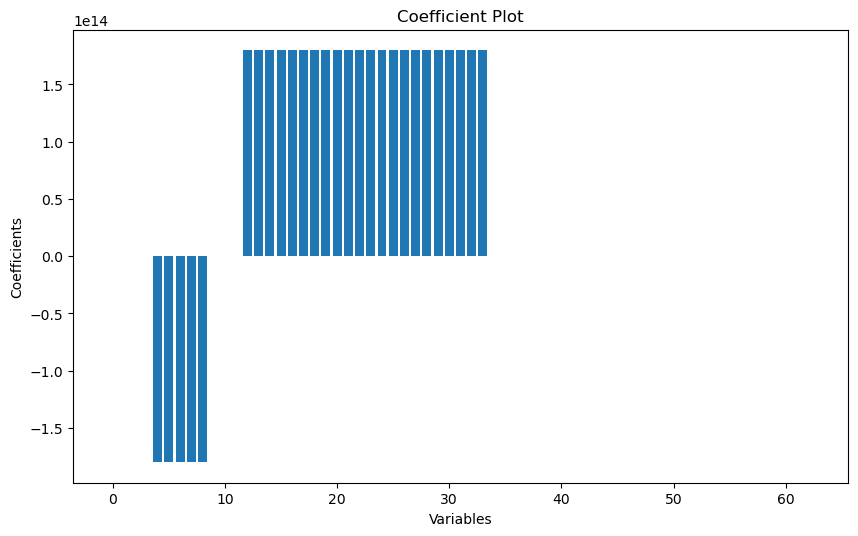

In [17]:
# Plotting the coefficients:
plt.figure(figsize=(10,6),dpi=100)
x_ = range(len(train_X.columns))
y_ = regressor.coef_
plt.bar(x_,y_)
plt.xlabel('Variables')
plt.ylabel('Coefficients')
plt.title('Coefficient Plot')
plt.show()

#Testing assumptions of Linear regression:

In [18]:
# Calculating Residuals:
residuals_df = pd.DataFrame(
    {'Actual values': test_y,
     'Predicted values': pred_y}
    ).reset_index(drop=True)
residuals_df['residuals'] = residuals_df['Actual values'] - residuals_df['Predicted values']
residuals_df

,Actual values,Predicted values,residuals
0,236,616.014578,-380.014578
1,898,706.240518,191.759482
2,980,639.068477,340.931523
3,585,369.748330,215.251670
4,446,461.303018,-15.303018
...,...,...,...
145426,1545,1849.537393,-304.537393
145427,1101,929.646768,171.353232
145428,209,-382.712607,591.712607
145429,864,571.428018,292.571982


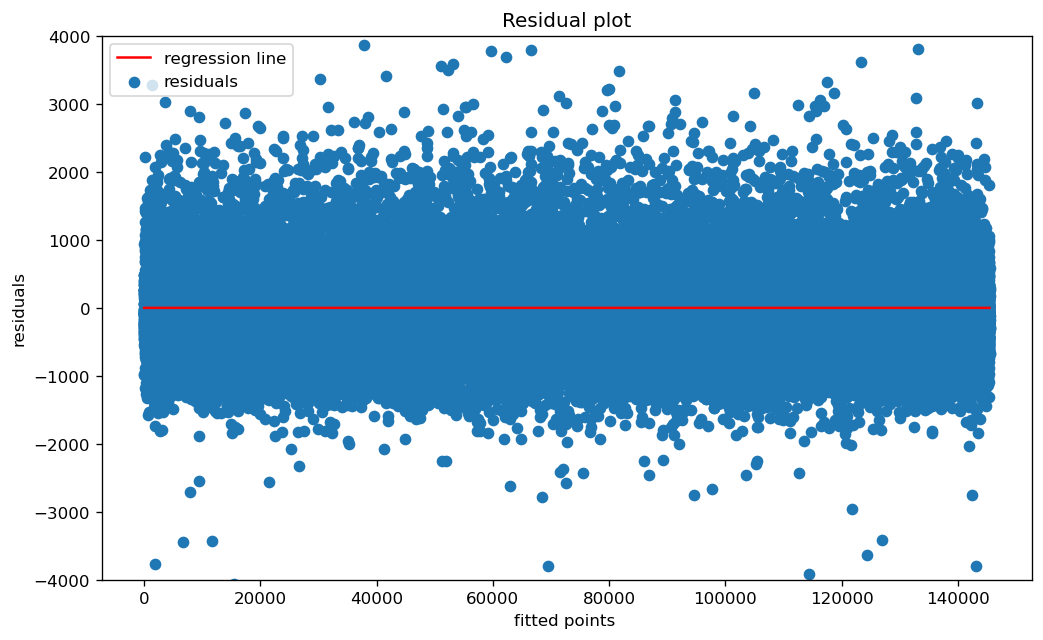

In [19]:
# Plotting resiudals to check for variance:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,145431)
k = [0 for i in range(0,145431)]
plt.scatter( f, residuals_df.residuals[:145431], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-4000, 4000)
plt.legend()
plt.show()

* The residual plot clearly looks homoscedastic, i.e the variance of the error across the dataset is nearly constant
* The residuals seem to be evenly distributed around the regression line and there is no visible pattern among the residuals
* So, there is no correlation amongh the residuals 

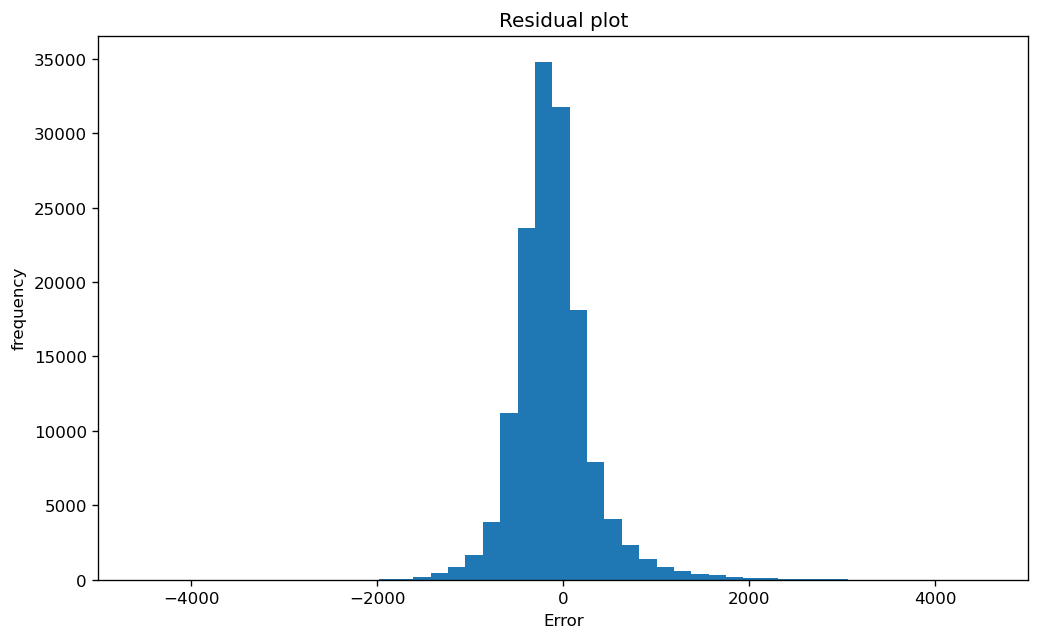

In [20]:
# Checking the distribution of the residuals:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals_df.residuals, bins=500, label = 'residuals')
plt.xlabel('Error')
plt.ylabel('frequency')
plt.title('Residual plot')
plt.xlim(-5000,5000)
plt.show()

* According to the histogram the residuals are almost normally distributed with very few outliers

<Figure size 1000x600 with 0 Axes>

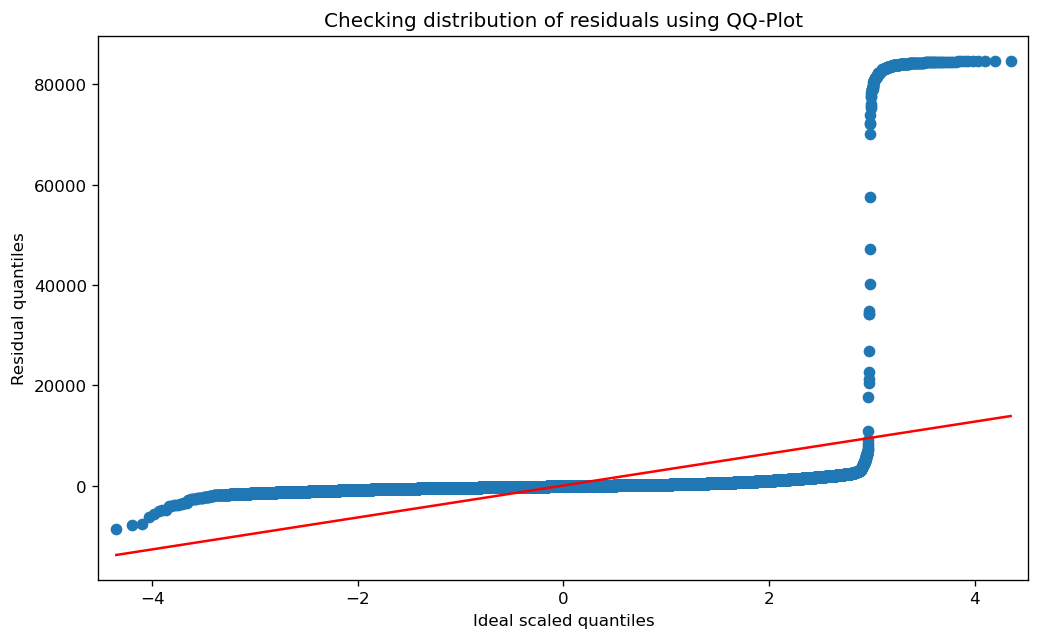

In [21]:
# QQ-plot to check and confirm if the residuals are normally distributed:
plt.figure(figsize=(10,6), dpi=100)
fig, ax = plt.subplots(figsize=(10,6) , dpi = 120)
qqplot(residuals_df.residuals, line='s', ax=ax)
plt.xlabel('Ideal scaled quantiles')
plt.ylabel('Residual quantiles')
plt.title('Checking distribution of residuals using QQ-Plot')
plt.show()

* Although most of the residuauals are following normal distribution, clearly there are good amount of outliers indicating that residual distributio is skewed

In [22]:
## This code takes too long to run and hence is commented for now:
# Calculating Multicollinearity:
vif_df = pd.DataFrame()
vif_df['features'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]

vif_df

,features,VIF
0,trip_distance,2.603369
1,trip_speed,6.729424
2,flag_Y,1.013058
3,vendor_id_2,2.337501
4,month_2,inf
...,...,...
58,passenger_count_2,1.208595
59,passenger_count_3,1.061953
60,passenger_count_4,1.028495
61,passenger_count_5,1.141083


In [23]:
# Checking if any independent variable has a multicollinearity greater than or equal to 5:
vif_df.loc[vif_df['VIF'] >= 5].head()

# Removing the column with high multicollinearity:
train_X_adjusted_cols = train_X.drop('trip_speed', axis=1)
test_X_adjusted_cols = test_X.drop('trip_speed', axis=1)

* Trip speed has a multicollinearity greater than 5. So we remove this variable and train the model again

In [24]:
#Linear regressor without features with high multicollinearity:
regressor2 = LinearRegression() 
regressor2.fit(train_X_adjusted_cols, train_y) 

#Predict from the test features:
pred_y_adjusted_cols = regressor2.predict(test_X_adjusted_cols) 

In [25]:
#Evaluate the regressor on the raw data
print('MAE score for the Multiple LR removed vif is : {}'.format(mean_absolute_error(test_y,pred_y_adjusted_cols)))
print('MSE score for the Multiple LR removed vif is : {}'.format(mean_squared_error(test_y,pred_y_adjusted_cols)))
print('RMSE score for the Multiple LR removed vif is : {}'.format(np.sqrt(mean_squared_error(test_y,pred_y_adjusted_cols))))
print('Variance score for the Multiple LR removed vif is : %.2f' % regressor2.score(test_X_adjusted_cols, test_y))

MAE score for the Multiple LR removed vif is : 439.10677383086835
MSE score for the Multiple LR removed vif is : 10474429.942154916
RMSE score for the Multiple LR removed vif is : 3236.422398599249
Variance score for the Multiple LR removed vif is : 0.03


* Model accuracy did not imporve even after removing variables with high multicollinearity

In [26]:
# Arranging coefficients with features:
Coefficients_df = pd.DataFrame({
    'Variable'    : X.columns,
    'coefficient' : regressor.coef_
})
display(Coefficients_df.head())

# Choosing variables with significance greater than 0.5:
sig_var = Coefficients_df.loc[Coefficients_df.coefficient > 0.5]

# Exctracting those variables and putting them in a seperate dataframe:
X_significant_vars = nyc_trip_duration[sig_var['Variable'].values]

,Variable,coefficient
0,trip_distance,9.320246e+02
1,trip_speed,-7.245022e+02
2,flag_Y,-1.909721e+01
3,vendor_id_2,1.964736e+02
4,month_2,-1.798603e+14


In [27]:
# Splitting the data into train and test sets:
train_X2, test_X2, train_y2, test_y2 = train_test_split(X_significant_vars,y, test_size=0.20, random_state=11)

# Intializing and applying standard scaler:
scaler2 = StandardScaler()
train_X2[['trip_distance']] = scaler2.fit_transform(train_X2[['trip_distance']])
test_X2[['trip_distance']] = scaler2.transform(test_X2[['trip_distance']])

#Linear regressor for the raw data
regressor3 = LinearRegression() 
regressor3.fit(train_X2, train_y2) 

#Predict from the test features of raw data
pred_y_significant_vars = regressor3.predict(test_X2) 

#Evaluate the regressor on the raw data
print('MAE score for the Multiple LR raw is : {}'.format(mean_absolute_error(test_y2,pred_y_significant_vars)))
print('MSE score for the Multiple LR raw is : {}'.format(mean_squared_error(test_y2,pred_y_significant_vars)))
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(mean_squared_error(test_y2,pred_y_significant_vars))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor3.score(test_X2, test_y2))

MAE score for the Multiple LR raw is : 447.5701833298074
MSE score for the Multiple LR raw is : 10484997.704916693
RMSE score for the Multiple LR raw is : 3238.0546173461457
Variance score for the Multiple LR raw is : 0.03


* Model accuracy did not improve even after filtering out insignificant coefficients

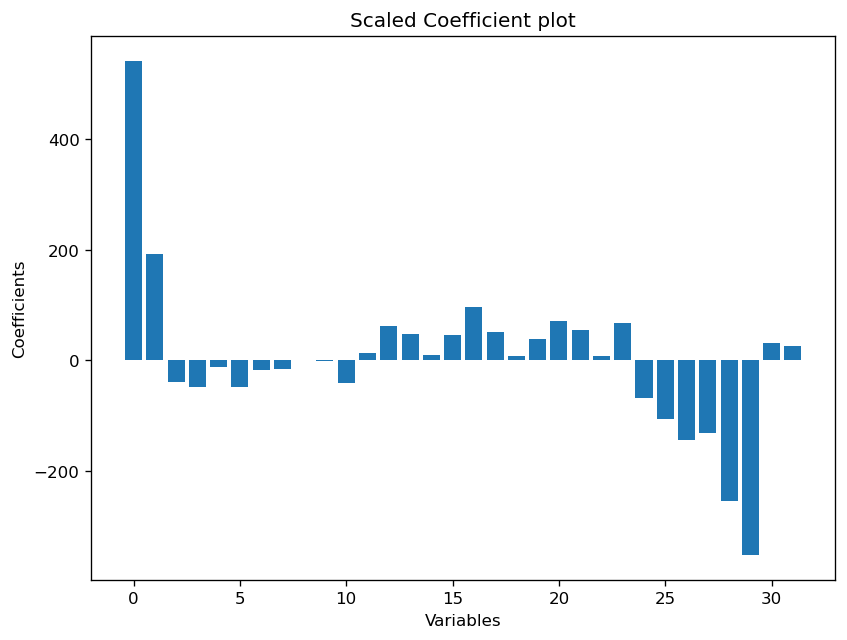

In [28]:
# Plotting the coefficients:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x_2 = range(len(train_X2.columns))
y_2 = regressor3.coef_
plt.bar(x_2, y_2 )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Scaled Coefficient plot')
plt.show()

##### Random Forest Regressor:

In [29]:
#instantiate the object for the Random Forest Regressor with default params from raw data
regressor_rfr= RandomForestRegressor(n_jobs=-1)
regressor_rfr.fit(train_X, train_y)

#Predict from the test features of raw data
pred_y_rfr = regressor_rfr.predict(test_X)

##### Model Evaluation:

In [30]:
#Evaluate the model with default params for Random Forest Regressor:
print('RMSE score for the RF regressor raw is : {}'.format(np.sqrt(mean_squared_error(test_y,pred_y_rfr))))
print('RMSLE score for the RF regressor raw is : {}'.format(np.sqrt(mean_squared_log_error(test_y,pred_y_rfr))))
print('Variance score for the RF regressor raw is : %.2f' % regressor_rfr.score(test_X, test_y))

RMSE score for the RF regressor raw is : 361.8710607356988
RMSLE score for the RF regressor raw is : 0.04074932163442589
Variance score for the RF regressor raw is : 0.99


##### Xgboost:

In [31]:
#instantiate the object for the XGBoost Regressor with default params for raw data
regressor_xgbraw = XGBRegressor(n_jobs=-1)
#Train the object with default params for raw data
regressor_xgbraw.fit(train_X, train_y)

#Predict the output with object of default params for raw data
y_pred_xgbraw = regressor_xgbraw.predict(test_X) 

In [32]:
# -----#### Note: This code takes too long to run and hence is commented for now ####-----
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1,n_jobs=4, cv=5)
# gsearch1.fit(train_X,train_y)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [33]:
#instantiate the object for the XGBoost Regressor with tuned hyper parameters for Feature Selection Group
regressor_xgb1 = XGBRegressor(n_estimators=300,
                              learning_rate=0.08,
                              gamma=0,
                              subsample=0.8,
                              colsample_bytree=1,
                              max_depth=8,
                              min_child_weight=4,
                              silent=1,
                              max_features='sqrt',
                              min_samples_leaf=50,
                              min_samples_split=500,
                              random_state=10,
                              n_jobs=-1,coord_descent='gpu')                 
         
#Train the object with tuned params for raw data
regressor_xgb1.fit(train_X, train_y)

#Predict the output with object of default params for raw data
y_pred_xgb1 = regressor_xgb1.predict(test_X)

[16:10:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "coord_descent", "max_features", "min_samples_leaf", "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




##### Model Evaluation:

In [34]:
#Evaluate the model with default params for raw data
print('RMSE score for the XGBoost regressor raw is : {}'.format(np.sqrt(mean_squared_error(test_y,y_pred_xgbraw))))
print('Variance score for the XGBoost regressor raw is : %.2f' % regressor_xgbraw.score(test_X, test_y))

print("\n")

RMSE score for the XGBoost regressor raw is : 277.45186078281824
Variance score for the XGBoost regressor raw is : 0.99




In [35]:
#Evaluate the model with tuned params for raw data
print('RMSE score for the XGBoost regressor is : {}'.format(np.sqrt(mean_squared_error(test_y,y_pred_xgb1))))
print('Variance score for the XGBoost regressor is : %.2f' % regressor_xgb1.score(test_X, test_y))

print("\n")

RMSE score for the XGBoost regressor is : 412.6382963572453
Variance score for the XGBoost regressor is : 0.98


